In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    plot_precision_recall_curve,
    average_precision_score
)
import pickle
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



# Loading

In [2]:
# Loads dtypes
types = pd.read_csv('./data/processed/transactions_dtypes.csv', index_col=0)
types_dict = types['0'].to_dict()
df = pd.read_csv('./data/processed/transactions.csv', index_col=0)
# sets loaded dtypes to dataframe
df = df.astype(types_dict)
# df = df.sample(100000)
df.shape

(776668, 36)

# Constants and Functions

In [3]:
RAND_STATE = 1234

In [4]:
def save_model(model, name):
    with open(f'{name}_{int(datetime.now().timestamp())}.pickle', 'wb') as f:
        pickle.dump(model, f)

In [5]:
def model_results(trained_model):

    try:
        print(f"Best Parameters: {trained_model.best_params_}")
    except AttributeError:
        pass
    
    print(
    f"training score: {trained_model.score(X_train, y_train)}",
    f"testing score: {trained_model.score(X_test, y_test)}"
    )
    y_pred_prob = trained_model.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_prob)}")
    threshold = average_precision_score(y_test, y_pred_prob)
    print(f"{threshold=}")
    y_pred = trained_model.predict(X_test)
    predictions = np.where(y_pred_prob > threshold, 1, 0)
    print("y_test distribution", np.bincount(y_test))
    print("prediction distribution", np.bincount(predictions == 1))

    # PR Curve
    plot_precision_recall_curve(trained_model, X_test, y_test)
    plt.show()
    
    # Plotting confusion Matrices
    f, axes = plt.subplots(1, 2, sharey=True, figsize=[15, 5])

    axes[0].set_title("Confustion Matrix 50/50")
    sns.heatmap(confusion_matrix(y_test.to_numpy(), y_pred), annot=True, fmt='g', ax=axes[0])

    axes[1].set_title("Confustion Matrix - Custom Threshold")
    sns.heatmap(confusion_matrix(y_test.to_numpy(), predictions), annot=True, fmt='g', ax=axes[1])
    plt.show()

In [6]:
def feature_importance(pipeline: Pipeline, X_train: pd.DataFrame):
    # Assumes Pipeline, with classifier as name
    importance = pd.Series(pipeline.best_estimator_.named_steps["classifier"].feature_importances_, index=X_train.columns)
    plt.figure( figsize = (10, 5) )
    importance.sort_values(ascending = False).plot.bar()
    plt.show()

# Splitting and Sampling 

In [7]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RAND_STATE)
X_train.shape


(582501, 35)

# Models

## Logistic Regression

### Basic

In [9]:
# Basic log regression with pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', LogisticRegression(random_state=RAND_STATE, n_jobs=-1))
    ])

In [10]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('selector', VarianceThreshold()),
                ('classifier',
                 LogisticRegression(n_jobs=-1, random_state=1234))])

In [11]:
save_model(pipeline, "logreg_pipeline")

training score: 0.9843897263695685 testing score: 0.984286722254554
ROC AUC Score: 0.7589314845386905
threshold=0.054598738030745504
y_test distribution [191165   3002]
prediction distribution [190222   3945]


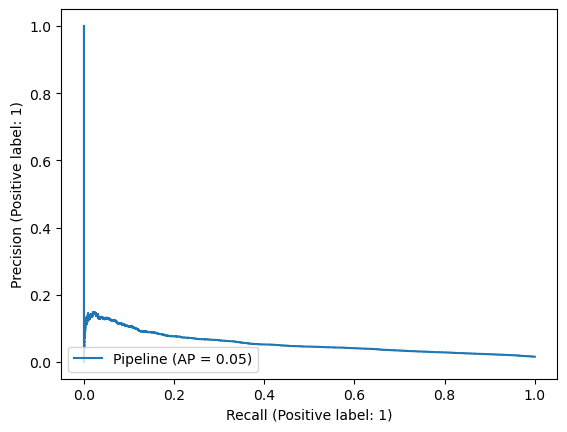

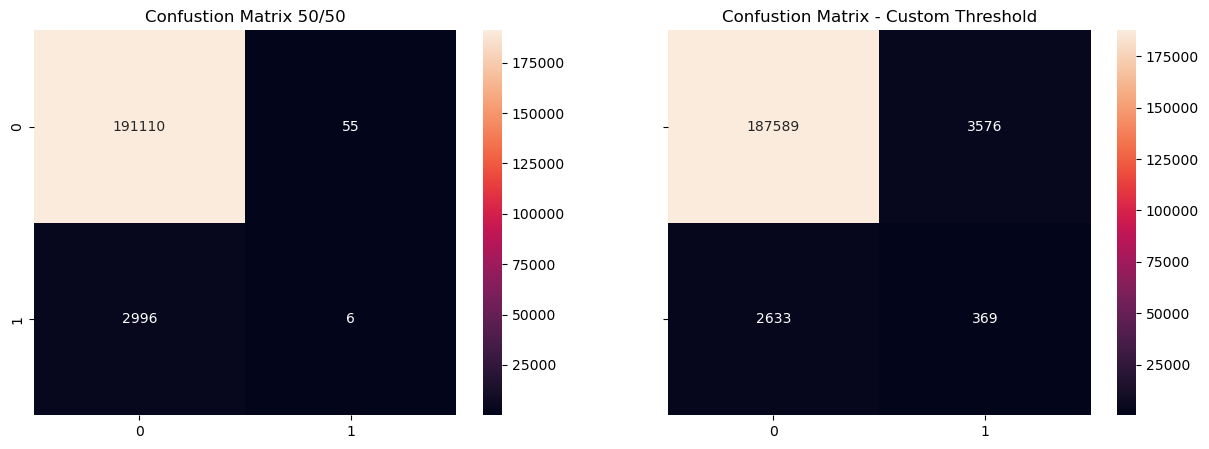

In [12]:
model_results(pipeline)

### Grid Search Pipeline

In [13]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold()),
    ('classifier', LogisticRegression(random_state=RAND_STATE, n_jobs=-1))
    ])

In [14]:
logreg_params = {
    'classifier__solver': ['newton-cg', 'lbfgs'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}
logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, scoring='roc_auc', refit=True, cv=5, n_jobs=-1)

In [15]:
logreg_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', VarianceThreshold()),
                                       ('classifier',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__solver': ['newton-cg', 'lbfgs']},
             scoring='roc_auc')

In [16]:
logreg_grid.cv_results_

{'mean_fit_time': array([11.36365266,  3.99428568, 14.87562814,  5.24747844, 18.34465141,
         6.60492978, 21.91842842,  8.10156159, 26.75383224,  9.02550988,
        30.84037385,  8.13846893]),
 'std_fit_time': array([0.2342008 , 0.31831801, 0.55382076, 0.05981364, 2.12076794,
        1.31163422, 2.24814003, 0.2785646 , 2.69251217, 0.39603637,
        2.48448486, 1.91340924]),
 'mean_score_time': array([0.162887  , 0.16368022, 0.18153687, 0.16744967, 0.17092199,
        0.18084264, 0.16526737, 0.162291  , 0.166854  , 0.16586251,
        0.14889894, 0.12708054]),
 'std_score_time': array([0.00844345, 0.02318157, 0.01257498, 0.00818391, 0.00671785,
        0.0188832 , 0.00458265, 0.00538227, 0.00415698, 0.00702543,
        0.03086305, 0.04034886]),
 'param_classifier__C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100,
                    100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fals

In [17]:
save_model(logreg_grid, "logreg_grid")

Best Parameters: {'classifier__C': 0.001, 'classifier__solver': 'lbfgs'}
training score: 0.7587922041565918 testing score: 0.7618033055949431
ROC AUC Score: 0.7618033055949431
threshold=0.05534959175441312
y_test distribution [191165   3002]
prediction distribution [191296   2871]


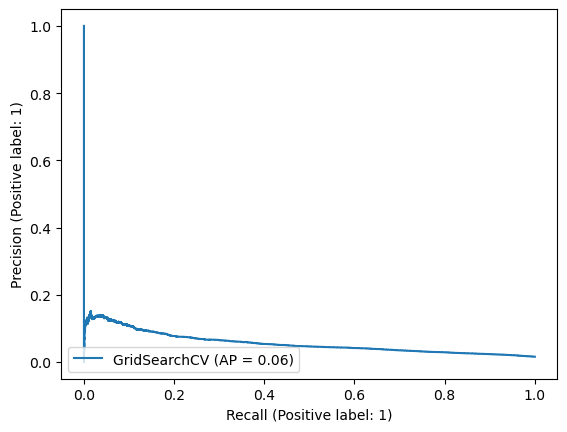

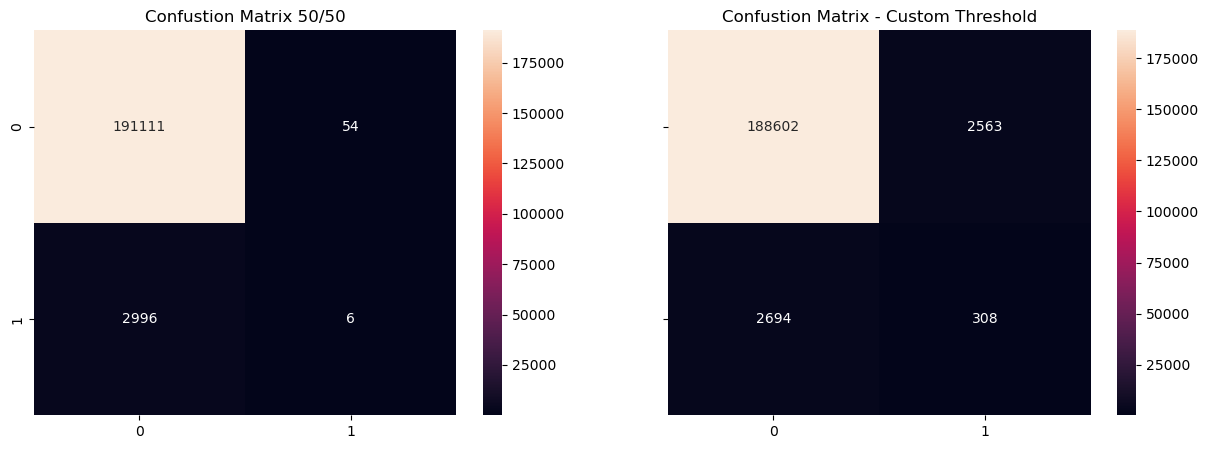

In [18]:
model_results(logreg_grid)

## Random Forest

In [19]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=RAND_STATE, n_jobs=-1)

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
    ])
rf_params = {
    'classifier__n_estimators': [80, 100, 120],
    'classifier__max_depth': [5],
    'classifier__max_features': [5, 6, 7]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='roc_auc', cv=5, n_jobs=-1, refit=True)


In [20]:
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5],
                         'classifier__max_features': [5, 6, 7],
                         'classifier__n_estimators': [80, 100, 120]},
             scoring='roc_auc')

In [21]:
save_model(rf_grid, "rf_grid")

Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 7, 'classifier__n_estimators': 120}
training score: 0.8018617510080556 testing score: 0.8006907477944807
ROC AUC Score: 0.8006907477944807
threshold=0.12153044321636358
y_test distribution [191165   3002]
prediction distribution [193824    343]


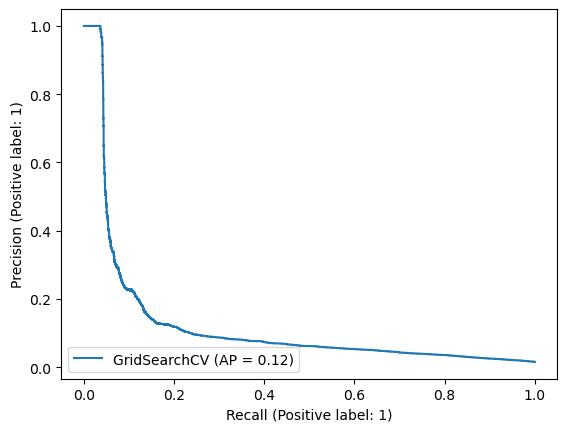

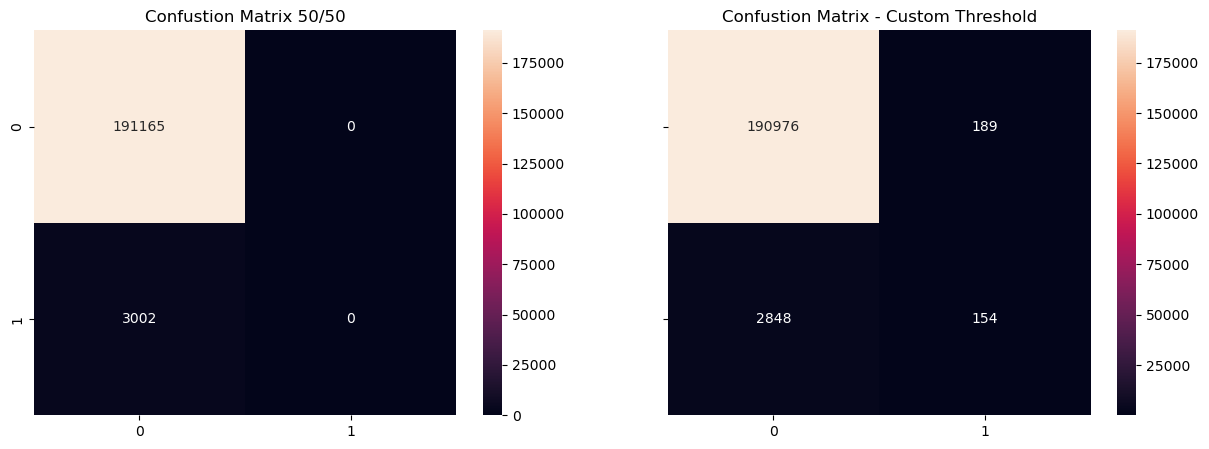

In [22]:
model_results(rf_grid)

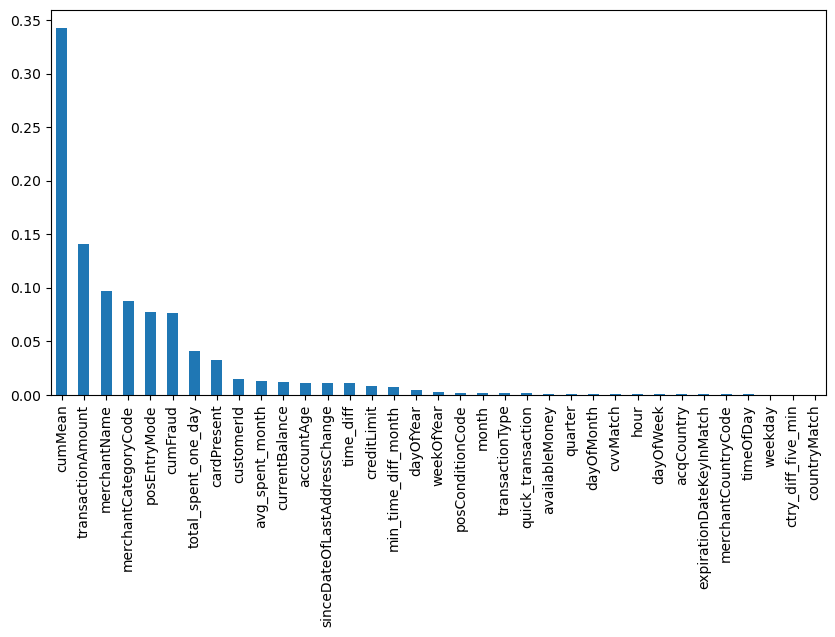

In [23]:
feature_importance(rf_grid, X_train)

## GradientBoostingClassifier

In [24]:
gb_model = GradientBoostingClassifier(random_state=RAND_STATE)
gb_pipeline = Pipeline([
    ('classifier', gb_model),
    ])
gb_params = {
    'classifier__max_depth': [3, 5, None],
    'classifier__max_features': [4, 6, 8]
}
gb_grid = GridSearchCV(gb_pipeline, gb_params, scoring='roc_auc', cv=5, n_jobs=-1, refit=True)

In [25]:
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier(random_state=1234))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, None],
                         'classifier__max_features': [4, 6, 8]},
             scoring='roc_auc')

In [26]:
save_model(gb_grid, "gb_grid")

Best Parameters: {'classifier__max_depth': 5, 'classifier__max_features': 8}
training score: 0.850229849547616 testing score: 0.8359943300077737
ROC AUC Score: 0.8359943300077737
threshold=0.17764175221426695
y_test distribution [191165   3002]
prediction distribution [193322    845]


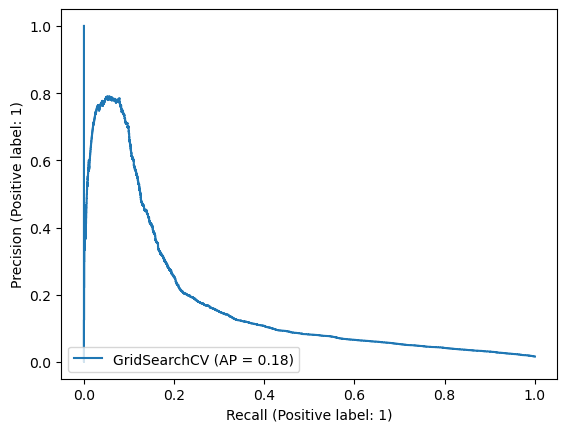

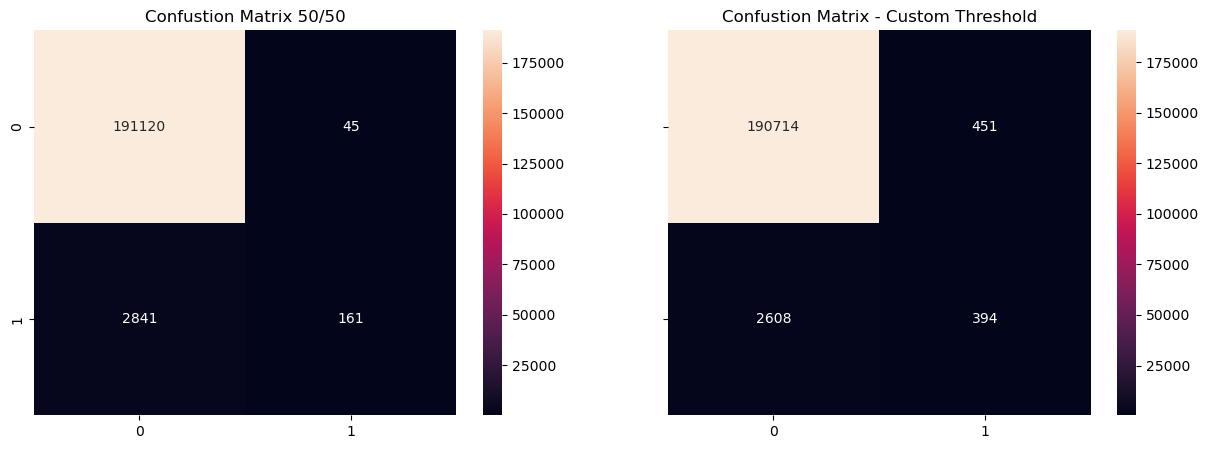

In [27]:
model_results(gb_grid)

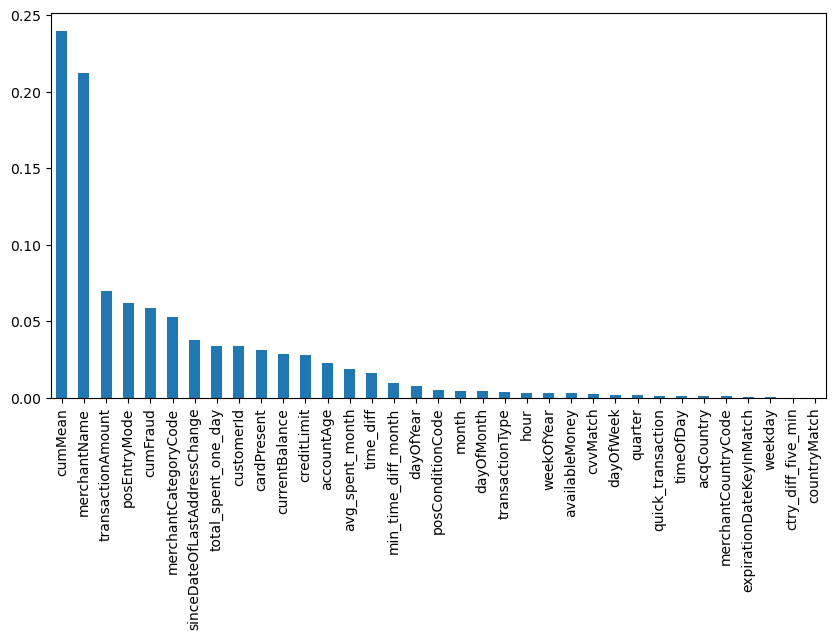

In [28]:
feature_importance(gb_grid, X_train)